In [6]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import os
import torch
import torch.nn as nn
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential


ModuleNotFoundError: No module named 'tensorflow'

In [3]:
(train, validation, test), info = tfds.load(
    
    "patch_camelyon",
    split = ["train", "validation", "test"],
    shuffle_files = True, 
    as_supervised = True,
    with_info = True,  
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/patch_camelyon/2.0.0.incomplete1Q3CKQ/patch_camelyon-test.tfrecord


  0%|          | 0/32768 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/patch_camelyon/2.0.0.incomplete1Q3CKQ/patch_camelyon-train.tfrecord


  0%|          | 0/262144 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/patch_camelyon/2.0.0.incomplete1Q3CKQ/patch_camelyon-validation.tfrecord


  0%|          | 0/32768 [00:00<?, ? examples/s]

Dataset patch_camelyon downloaded and prepared to /root/tensorflow_datasets/patch_camelyon/2.0.0. Subsequent calls will reuse this data.


In [4]:
print(info)

tfds.core.DatasetInfo(
    name='patch_camelyon',
    version=2.0.0,
    description='The PatchCamelyon benchmark is a new and challenging image classification
dataset. It consists of 327.680 color images (96 x 96px) extracted from
histopathologic scans of lymph node sections. Each image is annoted with a
binary label indicating presence of metastatic tissue. PCam provides a new
benchmark for machine learning models: bigger than CIFAR10, smaller than
Imagenet, trainable on a single GPU.',
    homepage='https://patchcamelyon.grand-challenge.org/',
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(96, 96, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=327680,
    splits={
        'test': 32768,
        'train': 262144,
        'validation': 32768,
    },
    supervised_keys=('image', 'label'),
    citation="""@misc{b_s_veeling_j_linmans_j_winkens_t_cohen_2018_

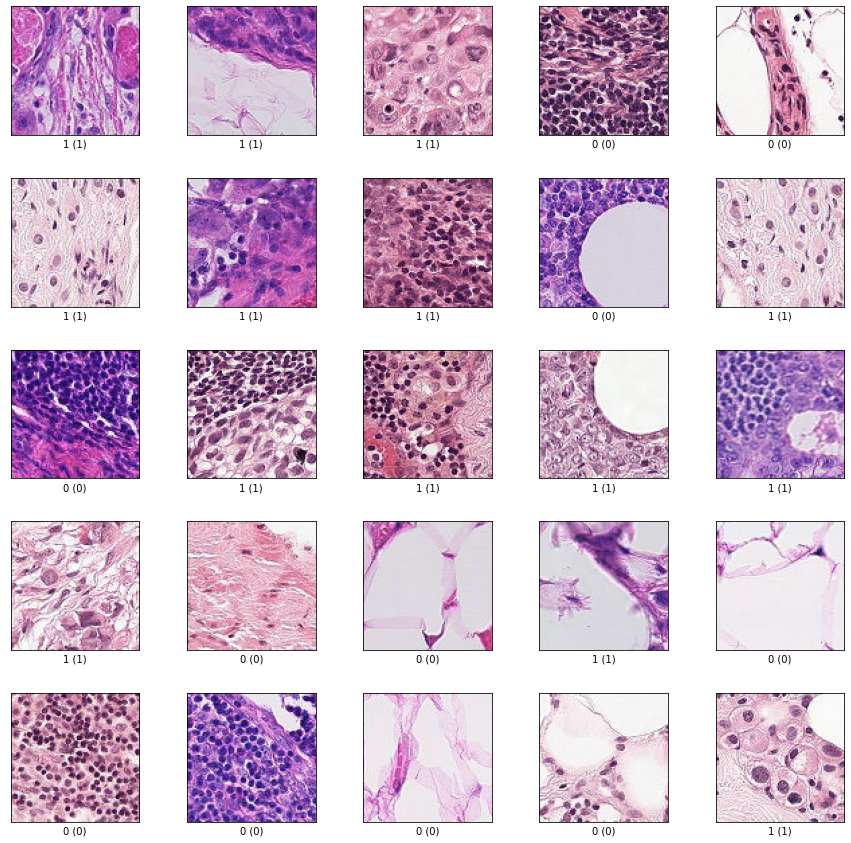

In [5]:
fig = tfds.show_examples(train, info, rows = 5, cols = 5)

In [6]:
# Normalize the images
def normalize(image, label):
  return tf.cast(image, tf.float16)/255.0, label

In [7]:
def augm(image_label, seed):
  image, label = image_label
  image, label = normalize(image, label)
  return image, label

In [1]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16

NameError: name 'tf' is not defined

In [9]:
counter = tf.data.experimental.Counter()
ds_train = tf.data.Dataset.zip((train, (counter, counter)))

In [10]:
train = train.map(normalize, num_parallel_calls = AUTOTUNE)
train = train.cache()
train = train.shuffle(info.splits["train"].num_examples)

train = train.batch(BATCH_SIZE)
train = train.prefetch(AUTOTUNE)

In [11]:
validation = validation.map(normalize, num_parallel_calls = AUTOTUNE)
validation = validation.batch(32)
validation = validation.prefetch(AUTOTUNE)

In [12]:
test = test.map(normalize, num_parallel_calls = AUTOTUNE)
test = test.batch(32)
test = test.prefetch(AUTOTUNE)

In [13]:
# Will stop the training/validation if the model does not improve accuracy in 5 consecutive epochs.
callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience = 5, verbose = 1)]

In [14]:
# Train on the taining data and run it on the validation ds.

In [36]:
# This is a block base for ResNet

class block(nn.Module):
  def __init__(self, input, out_channels, dimension_change = None, stride=1):
    super(block, self).__init__()
    self.expansion = 4
    self.conv1 = nn.Conv2d(input, out_channels, kernel_size = 1, stride = 1, padding = 1)
    self.bn1 = nn.BatchNorm2d(out_channels)

    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = stride, padding = 1)
    self.bn2 = nn.BatchNorm2d(out_channels)    

    self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size = 3, stride=1, padding=0)
    self.bn3 = nn.BatchNorm2d(out_channels*self.expansion)
    self.relu = nn.ReLU()
    self.dimension_change = id

  def forward(self, x):
    identity = x

    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu(x)
    x = self.conv3(x)
    x = self.bn3(x)

    if self.id is not None:
      identity = self.id(identity)

    x = x + identity
    x = self.relu(x)
    return x
  


In [30]:
class ResNet(nn.Module):
  def __init__(self, block, layers, image_channels, num_classes):
    super(ResNet, self).__init__()
    self.in_channels = 64
    self.conv1 = nn.Conv2d(image_channels, 64, kernel_size = 7, stride = 2, padding = 3)
    self.bn1 = nn.BatchNorm2d(64)
    self.relu = nn.ReLU()
    self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    self.layer1 = self.create_layer(block, layers[0], out_channels=64, stride=1)
    self.layer2 = self.create_layer(block, layers[1], out_channels=128, stride=2)
    self.layer3 = self.create_layer(block, layers[2], out_channels=256, stride=2)
    self.layer4 = self.create_layer(block, layers[3], out_channels=512, stride=2)

    self.avgpool = nn.AdaptiveAvgPool2d((1,1))
    self.fc = nn.Linear(512*4, num_classes)
 
  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)

    x = self.avgpool(x)
    x = x.reshape(x.shape[0], -1)
    x = self.fc(x)

    return x


  def create_layer(self, block, num_blocks, out_channels, stride):
    downsample = None
    layers = []

    if stride !=1 or self.in_channels != out_channels * 4:
      downsample = nn.Sequential(nn.Conv2d(self.in_channels, out_channels*4, kernel_size=1, stride=stride), nn.BatchNorm2d(out_channels*4))
      layers.append(block(self.in_channels, out_channels, downsample, stride))
      self.in_channels = out_channels*4

      for i in range(num_blocks -1):
        layers.append(block(self.in_channels, out_channels)) 

      return nn.Sequential(*layers)


#def ResNet50(img_channels, num_classes=1000):
#  return ResNet(block,[3, 4, 6, 3], img_channels, num_classes)

In [26]:
# Test function

def test():

  #ResNet-50 Architecture
  net = ResNet(block,[3, 4, 6, 3],3, num_classes=2)
  optimizer = torch.optim.SGD(net.parameters(), lr=0.02, momentum=0.9)

  for epoch in range(100):
    closs = 0
    for i, batch in enumerate(train,0):
      data,output = batch
      prediction = net(data)
      loss = nn.CrossEntropyLoss(prediction, output)
      closs = loss.item()

      optimizer.zero_gra()
      loss.backward()
      optimizer.step()

      if i%100 == 0:
        print('[%d  %d] loss: %.4f'% (epoch+1, i+1, closs/1000))
        closs = 0
    
    correctPred = 0
    total = 0

    for batches in validation:
      data, output = batches
      prediction = net(data)
      _,prediction = torch.max(prediction.data, 1) #returns max and its index
      total += output.size(0)
      correctPred += (prediction==output).sum().item()
    print('Accuracy on epoch ', epoch+1, '=', str((correctPred/total)*100))
  
  correctPred = 0
  total = 0
  for batches in validation:
    data, output = batches
    prediction = net(data)
    _,prediction = torch.max(prediction.data, 1) #returns max and its index
    total += output.size(0)
    correctPred += (prediction==output).sum().item()
  print('Accuracy on epoch ', epoch+1, '=', str((correctPred/total)*100))


In [ ]:
if __name__=='__main__':
  test()